# Notes on the Methods and Formulas

### Parameters
Parameters can be set in `configs.parameters.json`, for example:
```json
{
    "mc_horizon": 100,
    "mc_paths": 10000,
    "var_percentile": 0.1
}
```

#### The Graph (Compound-v2)
Used for current information on Compound. Total borrows, total supply, exchange rate, collateral factor and so on. 
Api at `src.the_graph_api.TheGraphAPI`. 

#### Coingecko (Historical Prices)
Use file: `data/coingecko_prices.csv`

Created by download script `download_historical_prices.py`. The script has a runtime of ~1h, because it sends about 600 requests to coingecko. The free API allows 10-50 requests per minute, so I use a sleep of 6 seconds to never send more than 10 requests per minute. 
Api at `src.coingecko_api.CoingeckoAPI`. 

Time window: `2022-11-21` to `2022-11-20`

Should be updated if gets too old compared to the timestamp of data from The Graph. 

### Volatility and Simulation of Trajectories
Calculated from the historical prices timeseries. Standard deviation of the log-returns. The log is used, because for the Monte Carlo method we model the price path by a Brownian Motion / Weiner Process, where the log-returns follow a Normal Distribution with $\mu=0$ and $\sigma=vol$. 

Implementation: `src.measures.calc_volatility`, `src.measures.monte_carlo_simulation`

### Value at Risk 
For the Value at Risk, I handled the protocol like a portfolio. Then got the distribution of `mc_paths` simulated returns, for `mc_horizon` days in the future. Then I looked at the "risk" percentile `var_percentile`, which gives a value of expected loss to that probability. A detailed description can be found further down, in the VaR-section. 
Result: 
> There is a 10% chance that the portfolio will have a return of less than 0.7510 within 100 days. (Return of 1 means same value as at beginning, >1 gain, <1 loss.)

### Runtime
The use of numpy and matrix multiplication keep the runtime low. On my machine (Intel MacBook Pro), the Monte Carlo Simulation of 10.000 * 17 paths for 100 days horizon only took 10 sec. 
Also the `calc_supply/borrow_value_usd` functions use matrix multiplication and return instantly (output 10.000 * 17).

What takes time is to download the historical prices, this is why the download code is excluded and here we load the prices from a csv.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json

from src.the_graph_api import TheGraphAPI

PRICES_FILE = Path.cwd().joinpath("data", "coingecko_prices.csv")
PARAMS_FILE = Path.cwd().joinpath("configs", "parameters.json")


In [2]:
# get current Compound Borrows from The Graph

tg_api = TheGraphAPI()
borrows = tg_api.get_compound_borrows()

col_dtypes = {
    "symbol":str,
    "underlyingSymbol":str,
    "underlyingName":str, 
    "totalBorrows":float,	
    "totalSupply":float,
    "collateralFactor":float,	
    "exchangeRate":float,
    "underlyingPriceUSD":float,	
    "underlyingPrice":float,
    "blockTimestamp":int,
    }
borrows_df = pd.DataFrame(borrows)
borrows_df = borrows_df.apply(lambda c: c.astype(col_dtypes[c.name]))
borrows_df

,symbol,underlyingSymbol,underlyingName,collateralFactor,exchangeRate,totalBorrows,totalSupply,underlyingPriceUSD,underlyingPrice,blockTimestamp
0,cUSDP,USDP,Pax Dollar,0.000,0.020195,1.973789e+04,1.473193e+06,1.000000,0.000862,1669192775
1,cTUSD,TUSD,TrueUSD,0.000,0.020554,5.487941e+06,3.924373e+08,1.000000,0.000858,1669211087
2,cREP,REP,Reputation,0.000,0.020041,5.590882e+01,5.470486e+04,6.961100,0.004323,1667094731
3,cUNI,UNI,Uniswap,0.750,0.020300,4.302875e+05,2.186814e+08,5.405000,0.004701,1669225271
4,cUSDC,USDC,USD//C,0.855,0.022680,2.519720e+08,2.964107e+10,1.000000,0.000869,1669225391
5,cSUSHI,SUSHI,SushiToken,0.700,0.020471,6.630254e+05,1.403794e+08,1.173423,0.001020,1669225079
6,cETH,ETH,Ether,0.825,0.020076,1.385448e+04,1.823654e+07,1149.862813,1.000000,1669225007
7,cDAI,DAI,Dai Stablecoin,0.835,0.022106,1.703099e+08,1.767044e+10,1.000134,0.000870,1669224827
8,cBAT,BAT,Basic Attention Token,0.650,0.020676,4.446289e+05,7.200996e+09,0.226898,0.000195,1669210835
9,cCOMP,COMP,Compound,0.650,0.020414,1.125100e+04,3.064799e+07,37.956006,0.033009,1669224695


Have two entries for `DAI` and `wBTC` each... only keep the bigger one for now
```
{
  "underlyingSymbol": "DAI",
  "underlyingName": "Dai Stablecoin",
  "borrowRate": "0.0233026004452608",
  "totalBorrows": "211524161.923877439677332104",
  "collateralFactor": "0.835",
  "underlyingPriceUSD": "1.000773",
  "blockTimestamp": 1669045535,
  "accrualBlockNumber": 16019369
},
{
  "underlyingSymbol": "DAI",
  "underlyingName": "Dai Stablecoin v1.0 (DAI)",
  "borrowRate": "0.0501467542606656",
  "totalBorrows": "240.64852988575940222",
  "collateralFactor": "0",
  "underlyingPriceUSD": "6.210826",
  "blockTimestamp": 1668979619,
  "accrualBlockNumber": 16013904
},
....
{
  "underlyingSymbol": "WBTC",
  "underlyingName": "Wrapped BTC",
  "borrowRate": "0.0206864728473312",
  "totalBorrows": "0.39387562",
  "collateralFactor": "0.7",
  "underlyingPriceUSD": "15929.996902",
  "blockTimestamp": 1669001867,
  "accrualBlockNumber": 16015751
},
{
  "underlyingSymbol": "WBTC",
  "underlyingName": "Wrapped BTC",
  "borrowRate": "0.0221761103560704",
  "totalBorrows": "152.21575285",
  "collateralFactor": "0.7",
  "underlyingPriceUSD": "16182.771321",
  "blockTimestamp": 1669043411,
  "accrualBlockNumber": 16019192
},
```

In [3]:
borrows_df = borrows_df.sort_values(by=["underlyingSymbol", "totalBorrows"], ascending=False).reset_index(drop=True)
borrows_df = borrows_df.drop_duplicates(subset=["underlyingSymbol"])
borrows_df = borrows_df.sort_values(by=["underlyingSymbol"]).reset_index(drop=True)
borrows_df

,symbol,underlyingSymbol,underlyingName,collateralFactor,exchangeRate,totalBorrows,totalSupply,underlyingPriceUSD,underlyingPrice,blockTimestamp
0,cAAVE,AAVE,Aave Token,0.730,0.020307,7.522081e+03,7.696866e+05,57.092842,0.049652,1669224731
1,cBAT,BAT,Basic Attention Token,0.650,0.020676,4.446289e+05,7.200996e+09,0.226898,0.000195,1669210835
2,cCOMP,COMP,Compound,0.650,0.020414,1.125100e+04,3.064799e+07,37.956006,0.033009,1669224695
3,cDAI,DAI,Dai Stablecoin,0.835,0.022106,1.703099e+08,1.767044e+10,1.000134,0.000870,1669224827
4,cETH,ETH,Ether,0.825,0.020076,1.385448e+04,1.823654e+07,1149.862813,1.000000,1669225007
5,cFEI,FEI,Fei USD,0.000,0.020136,2.496479e+03,8.882565e+04,0.997575,0.000624,1667774747
6,cLINK,LINK,ChainLink Token,0.790,0.020171,2.485233e+04,3.453725e+07,6.429054,0.005545,1669218695
7,cREP,REP,Reputation,0.000,0.020041,5.590882e+01,5.470486e+04,6.961100,0.004323,1667094731
8,cSUSHI,SUSHI,SushiToken,0.700,0.020471,6.630254e+05,1.403794e+08,1.173423,0.001020,1669225079
9,cTUSD,TUSD,TrueUSD,0.000,0.020554,5.487941e+06,3.924373e+08,1.000000,0.000858,1669211087


### Monte Carlo Simulation
- Calculate Volatilties
- Simulate Price Paths

In [4]:
from src.measures import calc_volatility, monte_carlo_simulation

with open(PARAMS_FILE) as f:
    params = json.load(f)
    
# load historical prices from coingecko (used scrip `download_historica_prices.ipynb` to prepare data)
prices = pd.read_csv(PRICES_FILE)
symbols = sorted(prices["symbol"].unique())

# calculate volatilities
vols = {}
for symbol in symbols:
    p = prices[prices["symbol"] == symbol]["price"].values
    vols[symbol] = calc_volatility(p)

print(vols)

{'aave': 0.07464626572283103, 'bat': 0.06004059637910412, 'comp': 0.06638834095565146, 'dai': 0.002007655992637203, 'eth': 0.06422278659986509, 'fei': 0.02851061647386272, 'link': 0.07018952104224735, 'rep': 0.07171938656321616, 'sushi': 0.09514300836715131, 'tusd': 0.00282056858179138, 'uni': 0.0697395479254225, 'usdc': 0.0021574718617547875, 'usdp': 0.0043466418878502005, 'usdt': 0.0019460020558690057, 'wbtc': 0.04429704461003883, 'yfi': 0.06864343781384731, 'zrx': 0.0728031524419769}


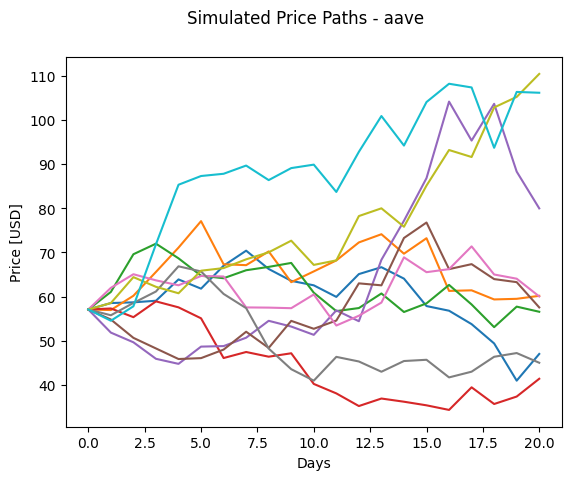

In [5]:
# plot example of Monte Carlo Paths (aave)
from src.measures import simulate_path
from src.plots import plot_mc_paths
from matplotlib import pyplot as plt

symbol = "aave"
price = borrows_df[borrows_df["underlyingSymbol"] == symbol.upper()]["underlyingPriceUSD"].iloc[0]
paths = [simulate_path(price, vols[symbol], horizon=20) for _ in range(10)]

fig = plot_mc_paths(symbol, paths)
plt.show()

In [6]:
# Simulate Monte Carlo Paths for all Symbols
mc_paths = {}
for symbol in symbols:
    price = borrows_df[borrows_df["underlyingSymbol"] == symbol.upper()]["underlyingPriceUSD"].iloc[0]
    mc_paths[symbol] = monte_carlo_simulation(price, vols[symbol], params["mc_horizon"], params["mc_paths"])

mc_prices = pd.DataFrame(mc_paths).T

print(f"For each asset simulated {params['mc_paths']} paths with time horizon of {params['mc_horizon']} days.")
print(f"Showing 10 example states:")
mc_prices[mc_prices.columns.tolist()[:10]]

For each asset simulated 10000 paths with time horizon of 100 days.
Showing 10 example states:


,0,1,2,3,4,5,6,7,8,9
aave,41.173309,110.362489,72.766557,45.596035,147.233756,28.168777,55.099397,250.088398,60.433480,269.515904
bat,0.108926,0.313429,0.174549,0.207805,0.179686,0.390645,0.519591,0.420785,0.291248,0.282839
comp,49.291701,38.330950,26.997341,36.724279,47.178060,163.179559,38.719569,44.180673,50.983047,8.393455
dai,0.981335,1.011036,1.021306,1.025637,1.016865,0.992185,0.989900,1.003383,1.022009,1.028573
eth,1734.330577,1745.967053,955.501306,816.371105,2212.579090,685.534370,1664.755071,554.366052,3150.204445,289.304162
fei,2.051178,0.780016,0.723110,1.118978,1.790417,1.104741,0.933173,0.762336,0.973988,1.153527
link,4.930860,21.912967,12.120051,10.175655,7.502877,2.659378,6.402588,1.747729,12.337544,5.166667
rep,5.483982,15.536780,3.133544,6.658424,3.052961,10.450438,11.757882,7.219186,7.607105,22.022374
sushi,2.135839,0.439486,2.914017,1.056696,1.081691,2.321753,9.408630,1.235621,2.072042,0.871713
tusd,0.999017,0.993479,0.995558,1.014547,1.007639,1.000370,1.002116,0.967102,1.014529,0.994494


# Calculate Value of Borrows and Collateral

- value of cTokens in USD: `amount_cToken * exchange_rate * price_usd`
- calculate `collateralValue` and `borrowValue` 

The `health` on Compound is `collateralValue / borrowValue`. A value of < 1 means, that the account is under-collateralized and subject to liquidation. The `health` value from the Compound API is calculated with the collateral and borrow values in ETH (`total_collateral_value_in_eth / total_borrow_value_in_eth.`). Since my simulation is based on the historic asset prices in USD, I will also calculate the health based on collateral and borrow value in USD. 

## Maximum Insolvency for an Account

To estimate the maximum Insolvency, we use the 10 simulated szenarios of assets prices. 

`borrowValue` for each asset is calculated using the field `borrow_balance_underlying` of the account. 

`collateralValue` is the sum of `supply_balance_underlying` multiplied by their `collatoralFactor`s. 

Then the Insolvency is `insolvency = borrowValue - collateralValue`. We do this 10 times (for the 10 simulated szenarios), and take the Maximum Insolvency Value. 

In [7]:
# get accounts from compound that are already close to insolvency (max_health = 1.5)

from src.compound_api import CompoundApi
c_api = CompoundApi()

accounts = c_api.get_accounts(amount=10, max_health=1.5)
pd.DataFrame(accounts)

,address,block_updated,health,tokens,total_borrow_value_in_eth,total_collateral_value_in_eth
0,0x0007808d13026d3245351759abc4f90a7bdd50de,None,{'value': '0.000000000000000000000000000000000...,[{'address': '0xc11b1268c1a384e55c48c2391d8d48...,{'value': '0.000002896172950578906501221108813'},{'value': '0.000000000000000000000000000000000...
1,0x00eb924da2c8bf07fe34258032384f5a82b19d52,None,{'value': '1.459307336298708098050227758685427...,[{'address': '0x70e36f6bf80a52b3b46b3af8e106cc...,{'value': '0.005012145515994565168423536456'},{'value': '0.007314260722087542740644256281'}
2,0xd9376c671bdab2030ad52c0e4283ea13a0b44c8e,None,{'value': '1.459087414872305520826108977490529...,[{'address': '0x39aa39c021dfbae8fac545936693ac...,{'value': '0.04882344048025790362826401539'},{'value': '0.07123766755551137933467886237'}
3,0xfbba892a4cdd9d01a67c62d0d8109850d3a640f3,None,{'value': '1.459008570855629146592668420158850...,[{'address': '0x5d3a536e4d6dbd6114cc1ead35777b...,{'value': '0.8202581420974200088557891583'},{'value': '1.196763659634250341918575504'}
4,0x758c1c81d24bbcb5cb9452f7356b8f4d99f9005e,None,{'value': '1.458891976889740024169454316050460...,[{'address': '0xccf4429db6322d5c611ee964527d42...,{'value': '1.660620519508445187688085726'},{'value': '2.422665952569342689717698061'}
5,0x4be0557d4aeb1675a1d5316e8a437dc934cface1,None,{'value': '1.458486429177290978879332134554338...,[{'address': '0x4ddc2d193948926d02f9b1fe9e1daa...,{'value': '0.01139050596895322041000842015'},{'value': '0.01661289837718120125700968857'}
6,0x35e1e04b759df13bd39a851ec6efd1ad1586973d,None,{'value': '1.458321845270577697566687025633972...,[{'address': '0x39aa39c021dfbae8fac545936693ac...,{'value': '0.4729167807260275766466099376'},{'value': '0.6896648723278017087656614507'}
7,0xd5b5459e3509bd48a1f37a6e1c482e60b70707b9,None,{'value': '1.458111851730012902270882266841115...,[{'address': '0xface851a4921ce59e912d19329929c...,{'value': '1.854201318622399092812569420'},{'value': '2.703632918176737997283690854'}
8,0x249d89ee6abadc95480bd840e13a81198aa186ad,None,{'value': '1.457959626606733176275105791853046...,[{'address': '0xface851a4921ce59e912d19329929c...,{'value': '385.4480215278892197313122758'},{'value': '561.9676535431054177594674481'}
9,0x5ce0d57a60330c2cc3106c9408986f79fe75e2c4,None,{'value': '1.457858264866442179039665545455769...,[{'address': '0x4ddc2d193948926d02f9b1fe9e1daa...,{'value': '0.000001754132355020488396165557584'},{'value': '0.000002557276351436255157673996208'}


In [8]:
# let's look at one account

a = accounts[4]
print(a["total_borrow_value_in_eth"], a["total_collateral_value_in_eth"], a["health"])
pd.DataFrame(a["tokens"])

{'value': '1.660620519508445187688085726'} {'value': '2.422665952569342689717698061'} {'value': '1.45889197688974002416945431605046076699783331977365022483049386659426034756211'}


,address,borrow_balance_underlying,lifetime_borrow_interest_accrued,lifetime_supply_interest_accrued,safe_withdraw_amount_underlying,supply_balance_underlying,symbol
0,0xccf4429db6322d5c611ee964527d42e5d685dd6a,{'value': '0.11544902019347808'},{'value': '0.00144902019347808'},{'value': '0.0'},{'value': '0.0'},{'value': '0.0'},cWBTC2
1,0x5d3a536e4d6dbd6114cc1ead35777bab948e3643,{'value': '18.096862182485612'},{'value': '512.453701026078612'},{'value': '0.0'},{'value': '0.0'},{'value': '0.0'},cDAI
2,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,{'value': '0'},{'value': '0'},{'value': '0.0125559214186470'},{'value': '0.4204730947682257040971723136'},{'value': '2.9365647909931427'},cETH


In [9]:
# calculate account's health using the usd value

def format_assets_to_df(tokens, field, colname):
    empty_tokens_df = pd.DataFrame(index=symbols)
    tokens = {t["symbol"][1:].lower(): float(t[field]["value"]) for t in tokens}
    df = pd.Series(tokens)

    empty_tokens_df[colname] = df
    empty_tokens_df.fillna(0, inplace=True)
    return empty_tokens_df

account_tokens = pd.DataFrame(index=symbols)
account_tokens["borrow"] = format_assets_to_df(a["tokens"], "borrow_balance_underlying", "borrow")
account_tokens["supply"]  = format_assets_to_df(a["tokens"], "supply_balance_underlying", "supply")
account_tokens

,borrow,supply
aave,0.000000,0.000000
bat,0.000000,0.000000
comp,0.000000,0.000000
dai,18.096862,0.000000
eth,0.000000,2.936565
fei,0.000000,0.000000
link,0.000000,0.000000
rep,0.000000,0.000000
sushi,0.000000,0.000000
tusd,0.000000,0.000000


In [10]:
from src.measures import calc_borrow_value_usd, calc_supply_value_usd

b = calc_borrow_value_usd(
    n_ctoken=account_tokens["borrow"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    prices=borrows_df["underlyingPriceUSD"].values
)

c = calc_supply_value_usd(
    n_ctoken=account_tokens["supply"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    collateral_factor=borrows_df["collateralFactor"].values,
    prices=borrows_df["underlyingPriceUSD"].values
)

print("health: ", c.sum()/b.sum())

health:  139.77967778689813


### How would the Monte Carlo simulated prices affect the supply and borrow vlaues?

In [11]:

from src.plots import plot_returns_histogram

mc_borrow_values = calc_borrow_value_usd(
    n_ctoken=borrows_df["totalBorrows"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    prices=mc_prices.values
)
mc_supply_values = calc_supply_value_usd(
    n_ctoken=borrows_df["totalSupply"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    collateral_factor=borrows_df["collateralFactor"].values,
    prices = mc_prices.values
)

# calculate simulated returns of portfolio
original_value = borrows_df["supplyValue"].sum() - borrows_df["borrowValue"].sum()
simulated_values = (mc_supply_values.sum(axis=0) - mc_borrow_values.sum(axis=0))
returns = simulated_values / original_value


fig = plot_returns_histogram(returns, params['mc_paths'])


KeyError: 'supplyValue'

In [ ]:
# return at the percentile (params["var_percentile"]):

var_critical_return = np.percentile(returns, q=params["var_percentile"])
print(f"There is a {int(params['var_percentile']*100)}% chance that the portfolio will have a return of less than {var_critical_return:.4f} within {params['mc_horizon']} days.")
print("Return of 1 means same value as at beginning, >1 gain, <1 loss.")

#### To Discuss:
- "For each price trajectory, measure the maximum insolvency of Compound."
- When asset is twice in graph list (wbtc, dai) only take the one with bigger borrows, drop the other.
- Exchange rate and collateral factor don't change?